Running on PyMC3 v3.5


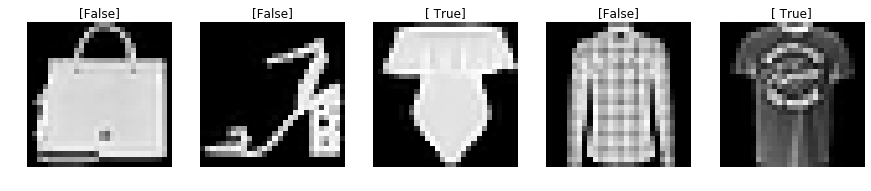

In [23]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pymc3 as pm
import theano
floatX = theano.config.floatX
import theano.tensor as T
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from warnings import filterwarnings
filterwarnings('ignore')
from utils.mnist_reader import load_mnist
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(10))
import theano.tensor as tt
print('Running on PyMC3 v{}'.format(pm.__version__))

# import fashion mnist data
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

# one hot encoding
#y_train = np.zeros((y_train_cat.shape[0],n_out))
#y_test = np.zeros((y_test_cat.shape[0],n_out))
#y_train[np.arange(y_train.shape[0]), y_train_cat] = 1
#y_test[np.arange(y_test.shape[0]), y_test_cat] = 1

# cast as theano float32
X_train = X_train.astype(floatX)/255
y_train = y_train.astype(floatX)<5
X_test = X_test.astype(floatX)/255
y_test = y_test.astype(floatX)<5

n_in = X_train.shape[1]
n_out = 2
n_train = X_train.shape[0]
n_test = X_test.shape[0]

label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# show a few samples
nsamples = 5
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
rndidx = np.random.choice(np.arange(n_train),size=(nsamples,1))
for i, idx in enumerate(rndidx):
    ax[i].imshow(np.reshape(X_train[idx],(28,28)),cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[idx.tolist()])
fig.show()

In [30]:
# now create a simple 3-layer bayesian neural network in pymc3
def construct_nn(ann_input, ann_output):
    n_hidden_1 = 64
    n_hidden_2 = 32
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(n_in, n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2,n_out).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1.2,
                                 shape=(n_in, n_hidden_1),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1.2,
                                shape=(n_hidden_1, n_hidden_2),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1.2,
                                  shape=(n_hidden_2,n_out),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = tt.nnet.softmax(pm.math.dot(act_2,
                                              weights_2_out))
        
        # testing Bernulli
        # Binary classification -> Bernoulli likelihood
        #out = pm.Bernoulli('out',
        #                   act_out,
        #                   observed=ann_output,
        #                   total_size=n_train # IMPORTANT for minibatches
        #                  )
        
        # Classification
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=n_train
                          )
    return neural_network

In [31]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(10000, method=inference)

Average Loss = 59.37: 100%|██████████| 10000/10000 [02:05<00:00, 79.38it/s]
Finished [100%]: Average Loss = 59.382


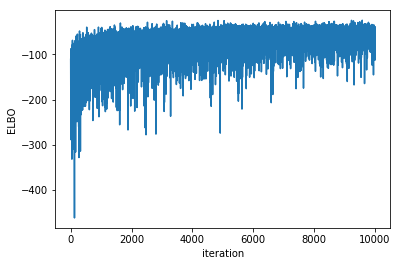

In [32]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.show()

In [33]:
trace = approx.sample(draws=2000)

In [34]:
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
neural_network_test = construct_nn(test_x, test_y)
with neural_network_test:
        ppc = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:50<00:00,  1.87it/s]


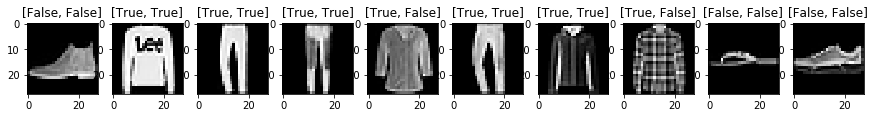

In [35]:
y_pred = mode(ppc['out'], axis=0).mode[0,:]==1
# show a few samples
nsamples = 10
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_test[i],(28,28)),cmap='gray')
    ax[i].set_title([y_pred[i],y_test[i]])
fig.show()

In [36]:
np.mean(y_pred==y_test)

0.8915

In [20]:
train_x = theano.shared(X_train)
train_y = theano.shared(y_train)
neural_network_train = construct_nn(train_x, train_y)
with neural_network_train:
        ppc_train = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:39<00:00,  2.15it/s]


In [22]:
y_pred = mode(ppc['out'], axis=0).mode[0,:]==1
np.mean(y_pred==y_train)

0.5001833333333333